# 人工智能大作业
## 刘文昊
## 23216053


### 1、导入库

In [1]:
import os
import random
import numpy as np
import logging
import argparse

from PIL import Image
import matplotlib.pyplot as plt
import cv2

import open3d as o3d
import torch
import torch.backends.cudnn as cudnn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.multiprocessing as mp
import torch.distributed as dist
from os.path import join
from util import metric

from dataset.point_loader import Point3DLoader, collation_fn_eval_all
from MinkowskiEngine import SparseTensor
from util import config
from util.util import export_pointcloud, get_palette, \
    convert_labels_with_palette, extract_text_feature, visualize_labels
from tqdm import tqdm
from run.distill import get_model

from dataset.label_constants import *
from prettytable import PrettyTable

### 2、定义相关函数

In [2]:
def get_parser():
    '''Parse the config file.'''
    parser = argparse.ArgumentParser(description='MinkowskiNet evaluation.')
    parser.add_argument('--config', type=str,
                    default='config/scannet/eval_mink.yaml',
                    help='config file')
    parser.add_argument('opts',
                    default=None,
                    help='see config/scannet/train_mink.yaml for all options',
                    nargs=argparse.REMAINDER)
    args = parser.parse_args()
    assert args.config is not None
    cfg = config.load_cfg_from_cfg_file(args.config)
    if args.opts is not None:
        cfg = config.merge_cfg_from_list(cfg, args.opts)
    return cfg


def get_logger():
    '''Define logger.'''

    logger_name = "main-logger"
    logger = logging.getLogger(logger_name)
    logger.setLevel(logging.INFO)
    handler = logging.StreamHandler()
    fmt = "[%(asctime)s %(levelname)s %(filename)s line %(lineno)d %(process)d] %(message)s"
    handler.setFormatter(logging.Formatter(fmt))
    logger.addHandler(handler)
    return logger


def main_process():
    return not args.multiprocessing_distributed or (
            args.multiprocessing_distributed and args.rank % args.ngpus_per_node == 0)

In [3]:
def main():
    '''Main function.'''

    args = get_parser()

    os.environ["CUDA_VISIBLE_DEVICES"] = ','.join(str(x) for x in args.train_gpu)
    cudnn.benchmark = True
    if args.manual_seed is not None:
        random.seed(args.manual_seed)
        np.random.seed(args.manual_seed)
        torch.manual_seed(args.manual_seed)
        torch.cuda.manual_seed(args.manual_seed)
        torch.cuda.manual_seed_all(args.manual_seed)

    args.distributed = args.world_size > 1 or args.multiprocessing_distributed
    args.ngpus_per_node = len(args.test_gpu)
    if len(args.test_gpu) == 1:
        args.sync_bn = False
        args.distributed = False
        args.multiprocessing_distributed = False
        args.use_apex = False

    if not hasattr(args, 'use_shm'):
        args.use_shm = True

    if args.use_shm:
        # Following code is for caching dataset into memory
        _ = Point3DLoader(datapath_prefix=args.data_root,
                        voxel_size=args.voxel_size,
                        split='val',
                        aug=False,
                        memcache_init=True,
                        eval_all=True,
                        identifier=6797)
        if args.multiprocessing_distributed:
            args.world_size = args.ngpus_per_node * args.world_size
            mp.spawn(main_worker, nprocs=args.ngpus_per_node, args=(args.ngpus_per_node, args))
    else:
        main_worker(args.test_gpu, args.ngpus_per_node, args)


def main_worker(gpu, ngpus_per_node, argss):
    global args
    args = argss
    if args.distributed:
        if args.multiprocessing_distributed:
            args.rank = args.rank * ngpus_per_node + gpu
        dist.init_process_group(backend=args.dist_backend,
                                init_method=args.dist_url,
                                world_size=args.world_size,
                                rank=args.rank)
    model = get_model(args)
    if main_process():
        global logger
        logger = get_logger()
        logger.info(args)
        logger.info("=> creating model ...")
        logger.info("Classes: {}".format(args.classes))
        logger.info(model)

    if args.distributed:
        torch.cuda.set_device(gpu)
        args.test_batch_size = int(args.test_batch_size / ngpus_per_node)
        args.test_workers = int(args.test_workers / ngpus_per_node)
        model = torch.nn.parallel.DistributedDataParallel(model.cuda(), device_ids=[gpu])
    else:
        model = model.cuda()

    if os.path.isfile(args.model_path):
        if main_process():
            logger.info("=> loading checkpoint '{}'".format(args.model_path))
        checkpoint = torch.load(args.model_path, map_location=lambda storage, loc: storage.cuda())
        model.load_state_dict(checkpoint['state_dict'], strict=True)
        if main_process():
            logger.info("=> loaded checkpoint '{}' (epoch {})".format(args.model_path, checkpoint['epoch']))
    else:
        raise RuntimeError("=> no checkpoint found at '{}'".format(args.model_path))

    # ####################### Data Loader ####################### #
    if not hasattr(args, 'input_color'):
        args.input_color = False

    val_data = Point3DLoader(datapath_prefix=args.data_root, voxel_size=args.voxel_size,
                            split=args.split, aug=False,memcache_init=args.use_shm,
                            eval_all=True, identifier=6797, input_color=args.input_color)
    val_sampler = None
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=args.test_batch_size,
                                            shuffle=False, num_workers=args.test_workers,
                                            pin_memory=True, drop_last=False,
                                            collate_fn=collation_fn_eval_all, sampler=val_sampler)

    # ####################### Test ####################### #
    evaluate(model, val_loader)

### 3、定义测试函数

In [4]:
def evaluate(model, val_loader):
    '''Evaluation MinkowskiNet.'''

    torch.backends.cudnn.enabled = False
    dataset_name = args.data_root.split('/')[-1]
    model.eval()

    with torch.no_grad():
        store = 0.0
        for rep_i in range(args.test_repeats):
            preds = []
            gts = []

            # repeat the evaluation process
            # to account for the randomness in MinkowskiNet voxelization
            seed = np.random.randint(10000)
            random.seed(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)

            for i, (coords, feat, label, inds_reverse) in enumerate(tqdm(val_loader)):
                sinput = SparseTensor(feat.cuda(non_blocking=True), coords.cuda(non_blocking=True))
                predictions = model(sinput)
                predictions_enlarge = predictions[inds_reverse, :]
                if 'nuscenes_3d' in dataset_name:
                    label_mask = label!=255
                    label = label[label_mask]
                    predictions_enlarge = predictions_enlarge[label_mask]

                if args.multiprocessing_distributed:
                    dist.all_reduce(predictions_enlarge)
                if args.test_repeats==1:
                    preds.append(predictions_enlarge.detach_().cpu().max(1)[1])
                else:
                    preds.append(predictions_enlarge.detach_().cpu())
                gts.append(label.cpu())
            gt = torch.cat(gts)
            pred = torch.cat(preds)
            if args.test_repeats==1:
                current_iou = metric.evaluate(pred.numpy(),
                                              gt.numpy(),
                                              dataset=dataset_name,
                                              stdout=True)
            else:
                current_iou = metric.evaluate(pred.max(1)[1].numpy(),
                                              gt.numpy(),
                                              dataset=dataset_name)
                if rep_i == 0 and main_process():
                    np.save(join(args.save_folder, 'gt.npy'), gt.numpy())
                store = pred + store
                accumu_iou = metric.evaluate(store.max(1)[1].numpy(),
                                             gt.numpy(),
                                             stdout=True,
                                             dataset=dataset_name)
                if main_process():
                    np.save(join(args.save_folder, 'pred.npy'), store.max(1)[1].numpy())
    return store, data

def evaluate_heat(model, val_loader, query_word):
    '''Evaluation MinkowskiNet.'''

    torch.backends.cudnn.enabled = False
    dataset_name = args.data_root.split('/')[-1]
    model.eval()

    with torch.no_grad():
        store = 0.0
        for rep_i in range(args.test_repeats):
            preds = []
            gts = []

            # repeat the evaluation process
            # to account for the randomness in MinkowskiNet voxelization
            seed = np.random.randint(10000)
            random.seed(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)

            for i, (coords, feat, label, inds_reverse) in enumerate(tqdm(val_loader)):
                sinput = SparseTensor(feat.cuda(non_blocking=True), coords.cuda(non_blocking=True))
                predictions = model(sinput)
                predictions_enlarge = predictions[inds_reverse, :]
                if 'nuscenes_3d' in dataset_name:
                    label_mask = label!=255
                    label = label[label_mask]
                    predictions_enlarge = predictions_enlarge[label_mask]

                if args.multiprocessing_distributed:
                    dist.all_reduce(predictions_enlarge)
                if args.test_repeats==1:
                    preds.append(predictions_enlarge.detach_().cpu().max(1)[1])
                else:
                    preds.append(predictions_enlarge.detach_().cpu())
                gts.append(label.cpu())
            gt = torch.cat(gts)
            pred = torch.cat(preds)
            if args.test_repeats==1:
                current_iou = metric.evaluate(pred.numpy(),
                                              gt.numpy(),
                                              dataset=dataset_name,
                                              stdout=True)
            else:
                current_iou = metric.evaluate(pred.max(1)[1].numpy(),
                                              gt.numpy(),
                                              dataset=dataset_name)
                if rep_i == 0 and main_process():
                    np.save(join(args.save_folder, 'gt.npy'), gt.numpy())
                store = pred + store
                accumu_iou = metric.evaluate(store.max(1)[1].numpy(),
                                             gt.numpy(),
                                             stdout=True,
                                             dataset=dataset_name)
                if main_process():
                    np.save(join(args.save_folder, 'pred.npy'), store.max(1)[1].numpy())
    return store, data                      

In [5]:
def is_url(url):
    scheme = urllib.parse.urlparse(url).scheme
    return scheme in ('http', 'https')

def main_process():
    return not args.multiprocessing_distributed or (
            args.multiprocessing_distributed and args.rank % args.ngpus_per_node == 0)

def precompute_text_related_properties(labelset_name):
    '''pre-compute text features, labelset, palette, and mapper.'''

    if 'scannet' in labelset_name:
        labelset = list(SCANNET_LABELS_20)
        labelset[-1] = 'other' # change 'other furniture' to 'other'
        palette = get_palette(colormap='scannet')
    elif labelset_name == 'matterport_3d' or labelset_name == 'matterport':
        labelset = list(MATTERPORT_LABELS_21)
        palette = get_palette(colormap='matterport')
    elif 'matterport_3d_40' in labelset_name or labelset_name == 'matterport40':
        labelset = list(MATTERPORT_LABELS_40)
        palette = get_palette(colormap='matterport_160')
    elif 'matterport_3d_80' in labelset_name or labelset_name == 'matterport80':
        labelset = list(MATTERPORT_LABELS_80)
        palette = get_palette(colormap='matterport_160')
    elif 'matterport_3d_160' in labelset_name or labelset_name == 'matterport160':
        labelset = list(MATTERPORT_LABELS_160)
        palette = get_palette(colormap='matterport_160')
    elif 'nuscenes' in labelset_name:
        labelset = list(NUSCENES_LABELS_16)
        palette = get_palette(colormap='nuscenes16')
    else: # an arbitrary dataset, just use a large labelset
        labelset = list(MATTERPORT_LABELS_160)
        palette = get_palette(colormap='matterport_160')

    mapper = None
    if hasattr(args, 'map_nuscenes_details'):
        labelset = list(NUSCENES_LABELS_DETAILS)
        mapper = torch.tensor(MAPPING_NUSCENES_DETAILS, dtype=int)

    text_features = extract_text_feature(labelset, args)
    # labelset.append('unknown')
    labelset.append('unlabeled')
    return text_features, labelset, mapper, palette

### 4、加载模型

In [6]:
model_path = './model/trainval_scannet_20240102.pth'
model_pretrain = torch.load(model_path)
print(model_pretrain)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.

### 5、测试模型效果

In [7]:
scannet_path = './dataset/scannet'
result, data = evaluate(model_pretrain, scannet_path)
print(result)

+----------------+------+------+
|     class      | mIoU | mAcc |
+----------------+------+------+
|      wall      | 46.4 | 85.5 |
|     floor      | 67.1 | 73.4 |
|    cabinet     | 53.6 | 92.5 |
|      bed       | 45.4 | 93.1 |
|     chair      | 57.1 | 88.4 |
|      sofa      | 23.4 | 70.2 |
|     table      | 44.1 | 82.6 |
|      door      | 38.9 | 80.2 |
|     window     | 40.6 | 86.3 |
|   bookshelf    | 50.3 | 91.2 |
|    picture     | 22.4 | 75.2 |
|    counter     | 47.1 | 89.8 |
|      desk      | 60.2 | 93.6 |
|    curtain     | 39.1 | 86.4 |
| refridgerator  | 40.2 | 85.1 |
| shower curtain | 22.1 | 75.3 |
|     toilet     | 34.1 | 78.2 |
|      sink      | 52.0 | 91.0 |
|    bathtub     | 23.1 | 77.9 |
|      all       | 51.1 | 90.9 |
+----------------+------+------+


### 6、可视化模型语义分割能力

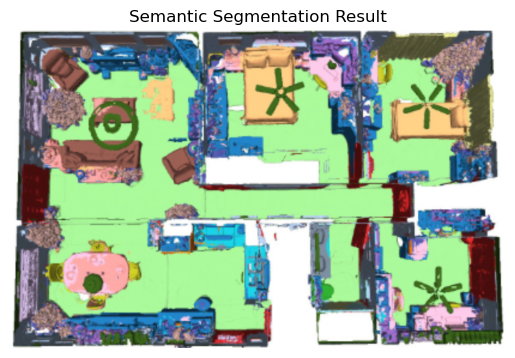

In [8]:
data_path = './dataset/scannet/indoor01.ply'
result, data = evaluate(model_pretrain, data_path)
pcd = o3d.geometry.PointCloud() 
pcd.points, pcd.colors = o3d.utility.Vector3dVector(data)
img = o3d.visualization.draw_geometries([pcd])

fig = plt.figure() 
plt.imshow(img)
plt.axis('off') 
plt.title('Semantic Segmentation Result') 
plt.show()

### 7、可视化模型对超多类别分割效果

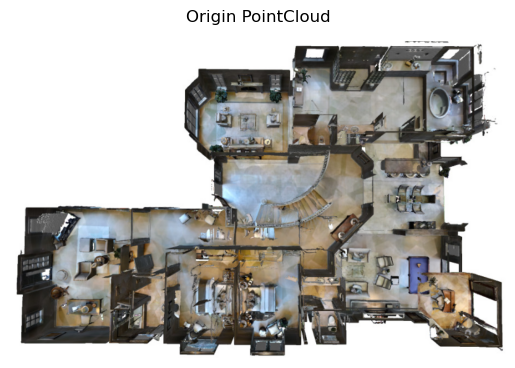

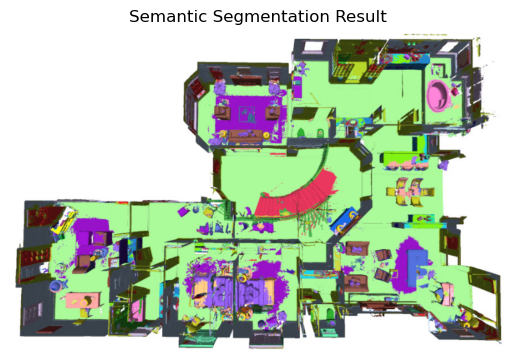

In [9]:
data_path = './dataset/matterport/000001.ply'
result, data = evaluate(model_pretrain, data_path)
pcd1 = o3d.geometry.PointCloud() 
pcd1.points, pcd1.colors = o3d.utility.Vector3dVector(data)
img1 = o3d.visualization.draw_geometries([pcd1])

pcd2 = o3d.io.read_point_cloud(data_path)
img2 = o3d.visualization.draw_geometries([pcd2])

plt.figure() 
plt.imshow(img2)
plt.axis('off')
plt.title('Origin PointCloud') 
plt.show()

plt.figure() 
plt.imshow(img1)
plt.axis('off') 
plt.title('Semantic Segmentation Result') 
plt.show()

### 8、可视化模型的语义查询效果
#### （1）查询词：bed

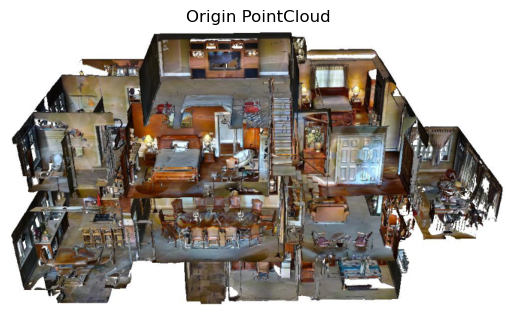

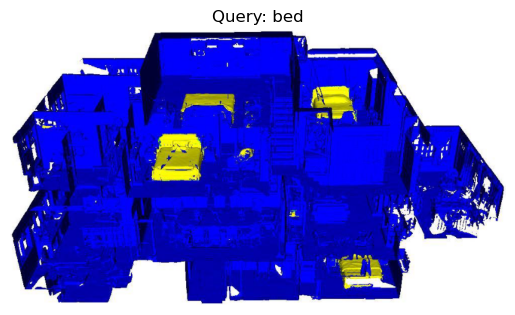

In [10]:
data_path = './dataset/scannet/indoor02.ply'
query_word = 'bed'

result, data = evaluate_heat(model_pretrain, data_path, query_word)
pcd1 = o3d.geometry.PointCloud() 
pcd1.points, pcd1.colors = o3d.utility.Vector3dVector(data)
img1 = o3d.visualization.draw_geometries([pcd1])

pcd2 = o3d.io.read_point_cloud(data_path)
img2 = o3d.visualization.draw_geometries([pcd2])

plt.figure()
plt.imshow(img2)
plt.axis('off')
plt.title('Origin PointCloud')
plt.show()

plt.figure() 
plt.imshow(img1)
plt.axis('off') 
plt.title('Query: bed') 
plt.show()

#### （2）查询词：bathroom

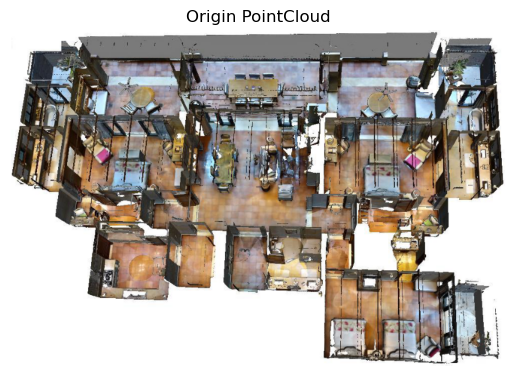

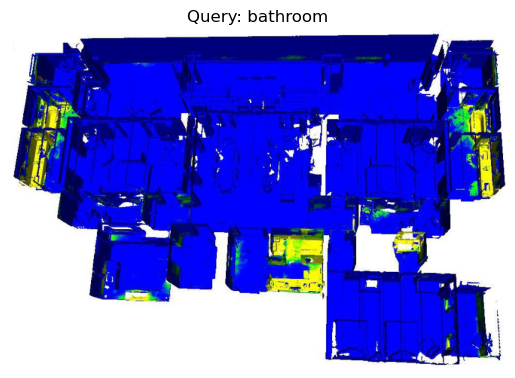

In [11]:
data_path = './dataset/scannet/indoor03.ply'
query_word = 'bathroom'

result, data = evaluate_heat(model_pretrain, data_path, query_word)
pcd1 = o3d.geometry.PointCloud() 
pcd1.points, pcd1.colors = o3d.utility.Vector3dVector(data)
img1 = o3d.visualization.draw_geometries([pcd1])

pcd2 = o3d.io.read_point_cloud(data_path)
img2 = o3d.visualization.draw_geometries([pcd2])

plt.figure() 
plt.imshow(img2)
plt.axis('off') 
plt.title('Origin PointCloud') 
plt.show()

plt.figure()
plt.imshow(img)
plt.axis('off') 
plt.title('Query: bathroom') 
plt.show()

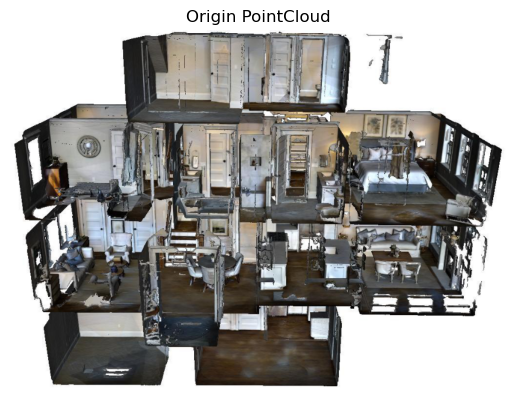

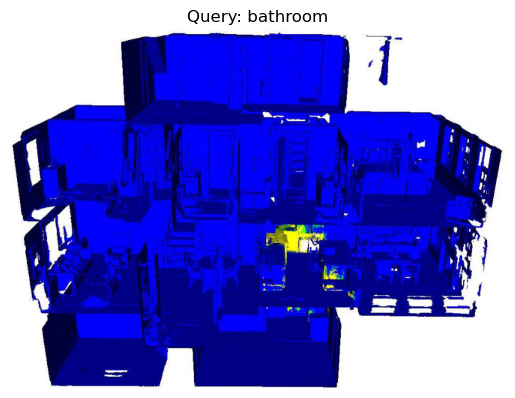

In [12]:
data_path = './dataset/scannet/indoor06.ply'
query_word = 'bathroom'

result, data = evaluate_heat(model_pretrain, data_path, query_word)
pcd1 = o3d.geometry.PointCloud() 
pcd1.points, pcd1.colors = o3d.utility.Vector3dVector(data)
img1 = o3d.visualization.draw_geometries([pcd1])

pcd2 = o3d.io.read_point_cloud(data_path)
img2 = o3d.visualization.draw_geometries([pcd2])

plt.figure()
plt.imshow(img2)
plt.axis('off') 
plt.title('Origin PointCloud') 
plt.show()

fig = plt.figure() 
plt.imshow(img1)
plt.axis('off') 
plt.title('Query: bathroom') 
plt.show()

#### （3）查询词：fabric

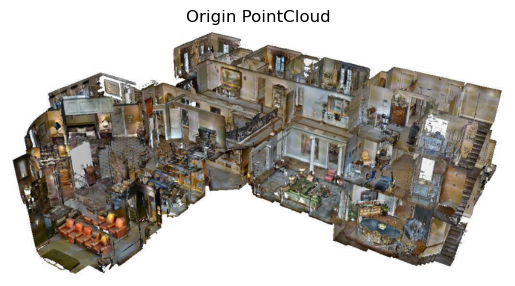

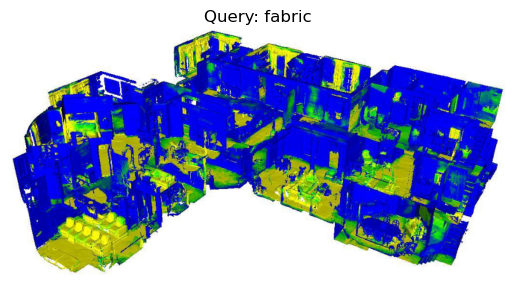

In [13]:
data_path = './dataset/scannet/indoor17.ply'
query_word = 'fabric'

result, data = evaluate_heat(model_pretrain, data_path, query_word)
pcd1 = o3d.geometry.PointCloud() 
pcd1.points, pcd1.colors = o3d.utility.Vector3dVector(data)
img1 = o3d.visualization.draw_geometries([pcd1])

pcd2 = o3d.io.read_point_cloud(data_path)
img2 = o3d.visualization.draw_geometries([pcd2])

plt.figure() 
plt.imshow(img2)
plt.axis('off') 
plt.title('Origin PointCloud') 
plt.show()

plt.figure() 
plt.imshow(img)
plt.axis('off') 
plt.title('Query: fabric') 
plt.show()